In [5]:
import os
import numpy as np 
import pandas as pd 
from datetime import datetime
import time
import random
from tqdm.auto import tqdm


#Torch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SequentialSampler, RandomSampler
import torchvision.transforms as T

#sklearn
from sklearn.model_selection import StratifiedKFold
from skimage import io

################# DETR FUCNTIONS FOR LOSS######################## 
import sys
sys.path.append('./detr_custom/')

from models.matcher import HungarianMatcher
from models.detr import SetCriterion
#################################################################

import matplotlib.pyplot as plt

#Glob
from glob import glob

from typing import Iterable
import albumentations as A
from albumentations.pytorch import ToTensorV2
from PIL import Image

In [6]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    
def pytorch_init_janus_gpu():
    device_id = 1
    torch.cuda.set_device(device_id)
    
    # Sanity checks
    assert torch.cuda.current_device() == 1, 'Using wrong GPU'
    assert torch.cuda.device_count() == 2, 'Cannot find both GPUs'
    assert torch.cuda.get_device_name(0) == 'GeForce RTX 2080 Ti', 'Wrong GPU name'
    assert torch.cuda.is_available() == True, 'GPU not available'
    return torch.device('cuda', device_id)

In [7]:
seed = 42069
seed_everything(seed)

try:
    device = pytorch_init_janus_gpu()
    print(f'Using device: {device} ({torch.cuda.get_device_name()})')
except AssertionError as e:
    print('GPU could not initialize, got error:', e)
    device = torch.device('cpu')
    print('Device is set to CPU')

Using device: cuda:1 (GeForce RTX 2080 Ti)


In [13]:
TORCH_CACHE_DIR = 'torch_cache'
torch.hub.set_dir(TORCH_CACHE_DIR)
model = torch.hub.load(os.path.join(TORCH_CACHE_DIR, 'facebookresearch_detr_master'), model='detr_resnet50', pretrained=True, source='local').to(device)

In [14]:
#.rotate creates black bars
img = Image.open('test_image2.png')
w, h = img.size

In [15]:
transform = T.Compose([
    T.Resize(800),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

In [16]:
input_img = transform(img)

In [17]:
with torch.no_grad():
    output = model(input_img.unsqueeze(0).to(device))

In [18]:
boxes = output['pred_boxes'][0]
logits = output['pred_logits'][0]

In [19]:
def postprocess(logits: torch.Tensor, boxes: torch.Tensor):
    keepmask = logits.softmax(-1)[:,:-1].max(-1)[0] > 0.7
    return logits[keepmask].argmax(-1), boxes[keepmask]

logits_, boxes_ = postprocess(logits, boxes)

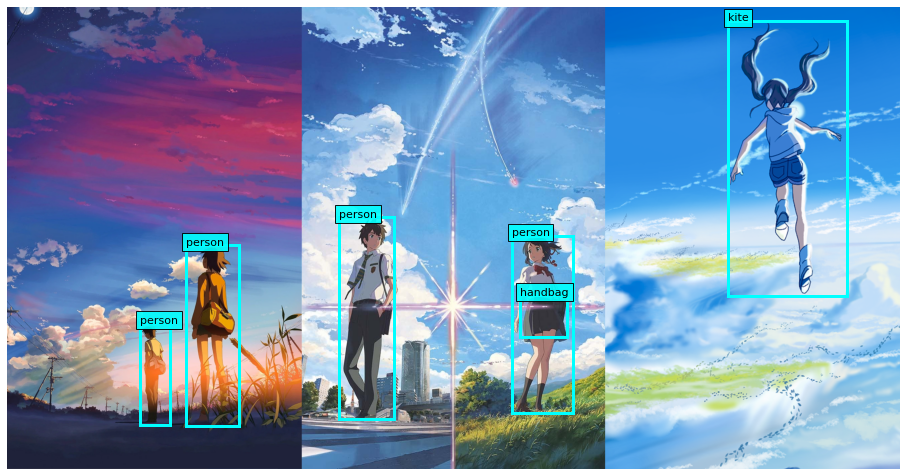

In [21]:
# COCO classes
CLASSES = [
    'N/A', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A',
    'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse',
    'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack',
    'umbrella', 'N/A', 'N/A', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis',
    'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove',
    'skateboard', 'surfboard', 'tennis racket', 'bottle', 'N/A', 'wine glass',
    'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich',
    'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake',
    'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table', 'N/A',
    'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard',
    'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A',
    'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier',
    'toothbrush'
]

def box_cxcywh_to_xyxy(x: torch.Tensor):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)

def plot_results(img: Image.Image, classes: Iterable, boxes: Iterable):
    boxes = box_cxcywh_to_xyxy(boxes)
    fig, ax = plt.subplots(figsize=(16,10))
    plt.imshow(img)
    
    w, h = img.size

    boxes[:,[0,2]] *= w
    boxes[:,[1,3]] *= h

    for cls, (xmin, ymin, xmax, ymax) in zip(classes, boxes):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color='cyan', linewidth=3))
        try:
            ax.text(xmin, ymin, CLASSES[cls], fontsize=11, bbox=dict(facecolor='cyan', alpha=0.9))
        except:
            pass
            
    plt.axis('off')
    plt.show()
    
plot_results(img, logits_, boxes_)